<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/AirQuality_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Linear Regression analysis of Air Quality dataset**

In [ ]:
! pip install pandas-profiling==3.2.0

In [ ]:
! pip install markupsafe==2.0.1

Importing necessary libraries:

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.stats as st

from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
from sklearn.linear_model import RidgeCV

Loading data:

In [ ]:
data = pd.read_csv('./AirQualityUCI.csv', sep=';')

Setting global constants:

In [ ]:
SEED = 844
TARGET = 'C6H6(GT)'

# EDA

In [ ]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


In [ ]:
data.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

In [ ]:
data.dtypes

Date              object
Time              object
CO(GT)            object
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)          object
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                 object
RH                object
AH                object
dtype: object

Combining Date and Time columns into one Timestamp and converting values into Datetime type:

In [ ]:
data['Timestamp'] = data['Date'] + ' ' + data['Time']
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d/%m/%Y %H.%M.%S')

In [ ]:
data.drop(['Date','Time'], axis=1, inplace=True)

In [ ]:
data.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Timestamp
0,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",2004-03-10 18:00:00
1,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",2004-03-10 19:00:00
2,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",2004-03-10 20:00:00
3,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",2004-03-10 21:00:00
4,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",2004-03-10 22:00:00


Converting all numeric columns to Float64 data type:

In [ ]:
obj_cols = list(data.select_dtypes(object))
for column in obj_cols:
  data[column]=data[column].str.replace(',','.')
  data[column] = data[column].astype(float)
data.dtypes

CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
Timestamp        datetime64[ns]
dtype: object

In [ ]:
data.isnull().sum()

CO(GT)           114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
Timestamp        114
dtype: int64

Dropping empty rows:

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


Replacing special value (-200) meaning "No Data" with NaN-s:

In [ ]:
data = data.replace(-200, np.nan)

Using PandasProfiling to get more detailed description of the data:

In [ ]:
profile = ProfileReport(data)

In [ ]:
profile

Pandas Profiling Report shows a few things about the data:
1. The most variables have high correlation with the target and also with each others. This might be the reason of multicolleniarity so we must keep an eye on it.
2. Three variables losely correlated with the target. So we probably can drop them later.
3. We have a lot of missing data in our dataset. One of the variables has data in less than 10% of the rows. I think that imputing these rows can affect the result significantly so I am definitely going to drop this variable.
Other variables which have 3-18% of missing values must be imputed. As we have here a time series I suppose that interpolation of the missing values using timestamps might work well.
4. We have a few duplicate rows which is better to drop.    

Dropping duplicates:

In [ ]:
data = data.drop_duplicates(keep=False)

Dropping variable with more then 90% of missing data:

In [ ]:
data.drop(['NMHC(GT)'], axis=1, inplace=True)

Dropping rows with missing target values:

In [ ]:
data = data.dropna(subset=['C6H6(GT)'])

# Target variable analysis

Top features correlated with the target:

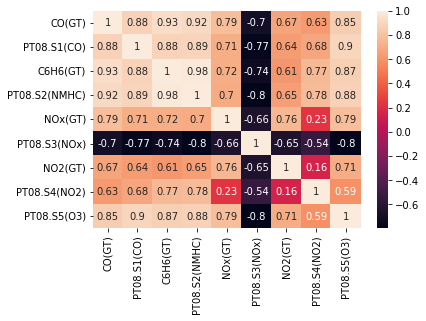

In [ ]:
corr = data.corr()
condition = np.abs(corr['C6H6(GT)']) > 0.5
top_corr = corr.loc[condition, condition]
sns.heatmap(top_corr, annot=True);

Here we can see high correlation coefficients between some of the independent variables. E.g. 'PT08.S2(NMHC)' has an absolute value of the correlation coefficients greater than 0.8 with 5 other variables. This might cause multicolliniarity issue so we must think of the solution (dropping highly correlated variables or perform PCA analysis).   

Looking at the distribution of the target:

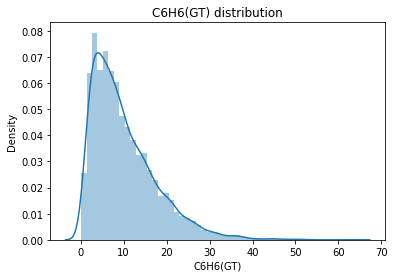

In [ ]:
ax = sns.distplot(data['C6H6(GT)'], norm_hist=True)
ax.set_title('C6H6(GT) distribution');

As we can see the distribution is quite skewed to the right and the range of the variable is quite wide. So we might try some nonlinear transformations of the target variable in order to make the distribution more normal.

Trying logarithm transformation of the target:

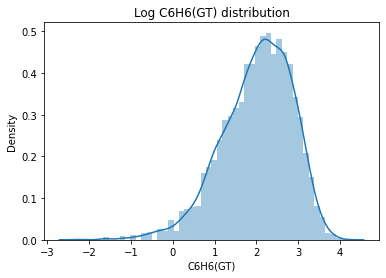

In [ ]:
ax = sns.distplot(np.log(data['C6H6(GT)']), norm_hist=True)
ax.set_title('Log C6H6(GT) distribution');

Using logarithm transformation we got a much narrower range of values and the distribution is much closer to the normal bell-shaped curve. But we still have a skewness, now to the left.

Trying squared root transformation:

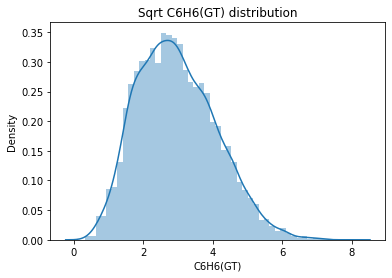

In [ ]:
ax = sns.distplot(np.sqrt(data['C6H6(GT)']), norm_hist=True)
ax.set_title('Sqrt C6H6(GT) distribution');

This curve is quite close to the normal. So I think it would be the best choise for the nonlinear transformation of the target.

# **Pipeline**

Almost all of our features are numerical so for the further iterating through them we put their names (excluding the target variable) into one list.

In [ ]:
NUMERICAL = data.select_dtypes(include=['float64']).columns.tolist()
if TARGET in NUMERICAL:
    NUMERICAL.remove(TARGET)

In [ ]:
NUMERICAL

['CO(GT)',
 'PT08.S1(CO)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

Performing linear interpolation of missing values:

In [ ]:
for col in NUMERICAL:
  data[col] = data[col].interpolate(method="linear")

In [ ]:
data.loc[(data['Timestamp'] > '2004-04-01 00:00:00') & (data['Timestamp'] < '2004-04-02 00:00:00')]

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Timestamp
511,1.2,1044.0,5.1,770.0,85.0,1031.0,70.0,1425.0,944.0,11.5,63.9,0.8652,2004-04-01 01:00:00
512,1.1,1034.0,4.1,716.0,50.0,1085.0,55.0,1405.0,891.0,10.7,67.2,0.8630,2004-04-01 02:00:00
513,0.9,956.0,4.0,713.0,53.5,1099.0,52.0,1422.0,849.0,9.0,73.1,0.8394,2004-04-01 03:00:00
514,0.7,909.0,2.4,615.0,57.0,1237.0,49.0,1322.0,790.0,10.2,66.6,0.8299,2004-04-01 04:00:00
515,0.9,996.0,2.9,648.0,64.0,1176.0,50.0,1340.0,852.0,11.0,63.7,0.8325,2004-04-01 05:00:00
516,1.7,1154.0,7.4,876.0,153.0,1002.0,67.0,1561.0,987.0,9.6,68.8,0.8243,2004-04-01 06:00:00
517,4.2,1510.0,19.8,1291.0,342.0,675.0,94.0,1949.0,1435.0,9.5,69.6,0.8273,2004-04-01 07:00:00
518,6.2,1722.0,31.9,1595.0,378.0,539.0,119.0,2439.0,1798.0,11.9,60.9,0.8455,2004-04-01 08:00:00
519,4.6,1512.0,21.0,1323.0,304.0,631.0,139.0,2001.0,1677.0,16.2,48.6,0.8892,2004-04-01 09:00:00
520,2.8,1258.0,11.7,1040.0,192.0,800.0,113.0,1701.0,1282.0,19.2,39.6,0.8693,2004-04-01 10:00:00


In [ ]:
data.isnull().sum()

CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Timestamp        0
dtype: int64

Generate features from all the independent variables using StandardScaler to standardize values:

In [ ]:
features = gen_features(
    columns=[[c] for c in NUMERICAL],
    classes=[
        {'class': StandardScaler}
    ]
)

Create DataFrameMapper from previously created features:

In [ ]:
mapper = DataFrameMapper(features)
len(features)

11

In [ ]:
df = data.copy()

In [ ]:
target = df[TARGET].values
df.drop(['Timestamp'], axis=1, inplace=True)


In [ ]:
X = df.drop(TARGET, axis=1)
y = target

Create X and y dataframes for further LR analysis:

In [ ]:
X_std = pd.DataFrame(mapper.fit_transform(X))
y_std = y


# PCA

I've decided to perform PCA in order to get rid of highly correlated features and reduce the dimensionality of the model.
The first step is to estimate what number of components will provide the explained variance close to 100% (98-99%)

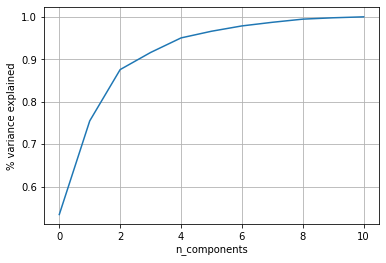

In [ ]:
pca = PCA(n_components = X_std.shape[1])
pca_data = pca.fit_transform(X_std)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [ ]:
cumm_var_explained

array([0.53431803, 0.75482853, 0.87575048, 0.91603646, 0.95034667,
       0.96605791, 0.97860458, 0.98714432, 0.99457363, 0.997784  ,
       1.        ])

From the plot above and values of cumm_var_explained I see that 5 of principal components give in sum 95% of variance. So further I am going to perform PCA with 5 components.   

In [ ]:
pca.explained_variance_

array([5.87815215, 2.42588531, 1.33028942, 0.44319503, 0.37745434,
       0.17284286, 0.13802871, 0.09394752, 0.08173156, 0.03531794,
       0.02437875])

Transform standardize variables from our dataset using PCA model:

In [ ]:
pca = PCA(n_components=5)
pca_train_data = pca.fit_transform(X_std)

Plotting heatmap of PCA 1-5 and the target:

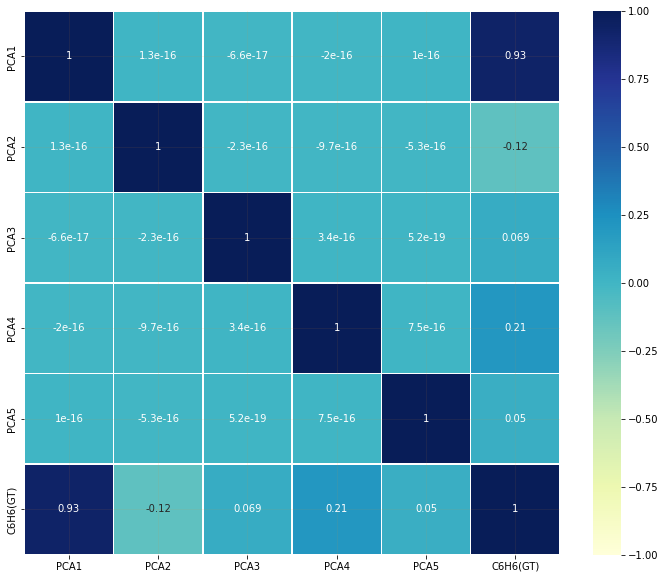

In [ ]:
df_train_pca = pd.DataFrame(pca_train_data, columns=['PCA1','PCA2','PCA3','PCA4','PCA5'])
df_train_pca[TARGET] = y_std

corr = df_train_pca.corr()
plt.figure(figsize = (12,10))

sns.heatmap(corr, annot = True, vmin=-1, vmax=1, cmap="YlGnBu", linewidths=.5)
plt.grid(b=True, color='#f68c1f', alpha=0.1)
plt.show()

We can see here that with PCA we avoided the situation with highly correlated independent variables. Now we have 5 variables loosely correlated with each other and actually just one of them has a significant correlation with the target.   

In [ ]:
aux_df = df_train_pca.copy()
aux_df.drop([TARGET, 'PCA3','PCA5'], axis=1, inplace=True)
colnames = aux_df.columns
# Redefine features
features = gen_features(
    columns=[[c] for c in aux_df],
    classes=[
        {'class': StandardScaler}
    ]
)

# Linear Regression

Splitting PCA dataframe into train and test parts. Dropping PCA components with near-to-zero correlation with the target variable (it was got empirically that dropping these components improves LR metrics) :

In [ ]:
X_pca = np.array(df_train_pca.drop([TARGET,'PCA3','PCA5'],axis=1))
y_pca = np.array(df_train_pca[TARGET])
X_train,X_test,y_train,y_test = train_test_split(X_pca, y_pca, random_state=SEED, shuffle=False, test_size=0.2)

Applying nonlinear transformation to the target. I've tried several options: Log, ^2, sqrt, 1/sqrt etc, finally chose sqrt as it gives better results.  

In [ ]:
train_X_tr = X_train
test_X_tr = X_test

train_y_tr = pd.Series(np.sqrt(y_train))
test_y_tr = pd.Series(np.sqrt(y_test))

Create and fit Linear Regression model. Print R2 score for the test data:

In [ ]:
linreg = LinearRegression()
linreg.fit(train_X_tr, train_y_tr)
print(f'\nR2 Test Score: {linreg.score(test_X_tr, test_y_tr)}')


R2 Test Score: 0.9500563436880232


In [ ]:
print(f'Predicted scores: {list(linreg.predict(test_X_tr))}')
print(f'Actual scores: {list(test_y_tr)}')

Predicted scores: [2.6234782339541685, 2.360234579240531, 2.279630949281574, 1.9678525373129938, 1.9997297047641824, 2.2379337852138184, 2.096035441997758, 2.230458573119074, 1.5423718383111031, 1.5102203448493685, 1.3720364090183195, 1.5599479274649355, 1.3014464694645458, 1.302674606444953, 1.5811456302478941, 1.6698007883603458, 1.7376370983279716, 2.3942843570169603, 2.4744542973837085, 1.9355271969030328, 1.7993620773919612, 2.0884888601632037, 1.8628335336266537, 1.7437174841128427, 1.695540970301213, 1.3409619946062532, 1.3021673343813418, 1.190071856967466, 1.4203775326686696, 1.7511304973113817, 3.6251134072378814, 3.859734265058537, 3.563535943210467, 3.786490696117078, 3.4007163745373936, 3.555360231340271, 3.552815814806709, 3.6727389707289473, 3.5324388294064235, 4.2472287653764935, 6.601138362000519, 6.25966315745527, 3.864561664944432, 3.482539467652341, 2.8111804135482115, 2.69053874672422, 2.497925891102488, 2.2311881010473114, 1.8723300196986317, 1.6596709396423117, 1

R2 score for the train data:

In [ ]:
print(f'\nR2 Train Score: {linreg.score(train_X_tr, train_y_tr)}')


R2 Train Score: 0.9462236160093705


Performing cross-validation: dataframe automatically divided to 5 parts, each part consequentially act as the test set, while the rest 4 become the training set.
Model calculates RMSE metric for 5 consequent tests in comparison with the RMSE metric received from the actual test set.

In [ ]:
#cross validation
def rmse(y_gt, Y_pr):
    return np.sqrt(mean_squared_error(y_gt, Y_pr))

print('RMSE Test: ')
print(rmse(test_y_tr, linreg.predict(test_X_tr)))
print('-'*30)

rmse_scorer = metrics.make_scorer(rmse)
print('RMSE cross-validation scores:')
CV_score = cross_val_score(linreg, train_X_tr, train_y_tr, cv=5, scoring=rmse_scorer, )
print(CV_score)
print('-'*30)

print('RMSE average cross-validation scores:')
print(np.sum(CV_score)/5)
print('-'*30)

RMSE Test: 
0.24465395287499053
------------------------------
RMSE cross-validation scores:
[0.40702854 0.24110985 0.24913873 0.2687908  0.31492516]
------------------------------
RMSE average cross-validation scores:
0.29619861883169535
------------------------------


Calculating metrics of LR model for the test dataset:

In [ ]:
#metrics
predictions = linreg.predict(test_X_tr)

mae = metrics.mean_absolute_error(test_y_tr, predictions)
mse = metrics.mean_squared_error(test_y_tr, predictions)
r2 = metrics.r2_score(test_y_tr, predictions)
rmse = np.sqrt(metrics.mean_squared_error(test_y_tr, predictions))

pd.DataFrame.from_dict({'MAE':mae, 'MSE':mse, 'R2':r2, 'RMSE':rmse}, orient='index', columns=['Score'])

,Score
MAE,0.195130
MSE,0.059856
R2,0.950056
RMSE,0.244654


It seems that the model is good.
As R2 is rather high (0.95) that means the model represents the variance of the target variable.
Another metrics (MAE, MSE, RMSE) which represent different measures of model's errors are quite small which I consider as a good sign also.

# Residual analisys

Plotting the residuals distribution in respect to index and true values:

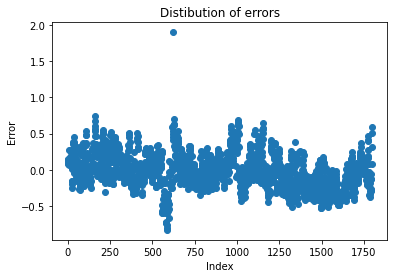

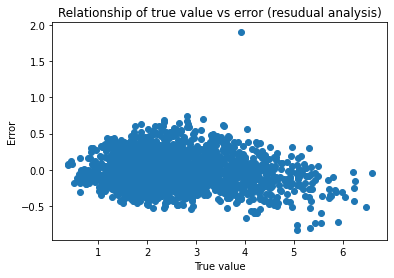

In [ ]:
#errors visualization
#can be helpful to better understand behavior of model

pred = linreg.predict(test_X_tr)
errors = test_y_tr - pred

plt.scatter(list(range(len(errors))),errors);
plt.title("Distibution of errors")
plt.ylabel('Error');
plt.xlabel('Index');
plt.show();

plt.scatter(pred,errors);
plt.title('Relationship of true value vs error (resudual analysis)')
plt.ylabel('Error');
plt.xlabel('True value');
plt.show();

In [ ]:
errors.mean()

-0.013655381944129024

As we can see on the plots residuals distributed rather randomly around the zero. There is no any obvious patterns  on the residuals plot that means there are not dependencies in our dataset which are not taken into account by our model.

Nevertheless, residuals are not distributed normally (see the test below). But taking into account the good model metrics we got it seems not so unacceptable.

In [ ]:
def normality_test(arr):
  alpha = 0.05
  stat, p = st.normaltest(errors)
  print(f"Alpha = {alpha}, p-value = {p}")
  if p < alpha:
    print("Null hypothesis could be rejected. The distribution isn't normal.")
  else:
    print("Null hypothesis couldn't be rejected. The distribution is normal.")

In [ ]:
normality_test(errors)

Alpha = 0.05, p-value = 1.3742892102800301e-27
Null hypothesis could be rejected. The distribution isn't normal.


# Regularization

Trying regularization - a method for constraining the size of the coefficients.It reduces model variance and minimizes overfitting.

First I am going to fit Ridge Regression (Linear Regression with Ridge regularizarion) with different values of the hyperparameter "alpha":

In [ ]:
alpha_range = np.arange(0.1, 0.16, 0.01)

for i in alpha_range:
  ridgereg = Ridge(alpha=i, normalize=True)
  ridgereg.fit(X_train, y_train)
  y_pred = ridgereg.predict(X_test)
# calculate R^2 value, MAE, MSE, RMSE
  print('alpha = ', i)
  print("R-Square ",r2_score(y_test,y_pred))
  print ("MAE :",metrics.mean_absolute_error(y_test, y_pred))
  print ("MSE : ",metrics.mean_squared_error(y_test, y_pred))
  print ("RMSE : ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  print("-"*30)

alpha =  0.1
R-Square  0.9266231003358334
MAE : 1.3838426297764193
MSE :  3.114327190382214
RMSE :  1.764745644670136
------------------------------
alpha =  0.11
R-Square  0.9273403071281057
MAE : 1.3726193961311766
MSE :  3.0838868661858645
RMSE :  1.7560999021086086
------------------------------
alpha =  0.12
R-Square  0.9278468204503043
MAE : 1.3631814972923206
MSE :  3.062388980354849
RMSE :  1.7499682798139082
------------------------------
alpha =  0.13
R-Square  0.928153684921732
MAE : 1.3554063431206218
MSE :  3.049364767400863
RMSE :  1.746243043622755
------------------------------
alpha =  0.13999999999999999
R-Square  0.928271358799376
MAE : 1.3491868726922787
MSE :  3.0443703487429254
RMSE :  1.7448124107602299
------------------------------
alpha =  0.14999999999999997
R-Square  0.9282097484736592
MAE : 1.3442392288220912
MSE :  3.046985268608252
RMSE :  1.7455615911815463
------------------------------


As we can see the best metrics occur at alpha = 0.14. The R2 metric (0.928) is lower than in our baseline model (0.95), and other metrics are higher. I don't know how to explain these results. Probably the regularization doesn't give any value to the basic LR model in our case.   

Next I am going to fit Lasso Regression (Linear Regression with Lasso regularizarion) with different values of the hyperparameter "alpha":

In [ ]:
alpha_range = np.arange(0, 0.006, 0.001)

for i in alpha_range:
  lassoreg = Lasso(alpha=i, normalize=True)
  lassoreg.fit(X_train, y_train)
  y_pred = lassoreg.predict(X_test)
# calculate MAE, MSE, RMSE
# calculate R^2 value, MAE, MSE, RMSE
  print('alpha = ', i)
  print ("R-Square ",r2_score(y_test,y_pred))
  print ("MAE :",metrics.mean_absolute_error(y_test, y_pred))
  print ("MSE : ",metrics.mean_squared_error(y_test, y_pred))
  print ("RMSE : ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  print("-"*30)

alpha =  0.0
R-Square  0.9049311080998121
MAE : 1.5990837445069872
MSE :  4.034997885701761
RMSE :  2.008730416382886
------------------------------
alpha =  0.001
R-Square  0.9090504963351399
MAE : 1.5623161773546907
MSE :  3.860159171505078
RMSE :  1.964728778102738
------------------------------
alpha =  0.002
R-Square  0.9104144752532333
MAE : 1.5506526641506773
MSE :  3.802267973441816
RMSE :  1.9499405051031213
------------------------------
alpha =  0.003
R-Square  0.9090231662237056
MAE : 1.566744957341678
MSE :  3.8613191402356426
RMSE :  1.9650239541124284
------------------------------
alpha =  0.004
R-Square  0.9048765692465564
MAE : 1.6069136913773858
MSE :  4.0373126718865695
RMSE :  2.0093065151655107
------------------------------
alpha =  0.005
R-Square  0.8979746843217862
MAE : 1.6686996627008828
MSE :  4.330248568394581
RMSE :  2.0809249309849167
------------------------------


Here we got the best metrics at alpha = 0.002. The R2 metric (0.91) is lower than in our baseline model (0.95), and other metrics are higher again. My conclusion is that regularization doesn't improve basic LR model in this case.

# Hyperparameter tuning

Unfortunately, this code that I take from the workshop stopped working after I applied PCA and I couldn't manage to find the reason for this. I leave it here to get back to the troubleshooting later.  

In [ ]:
# Evaluation

def evaluate_model(train, test, tr_y, tst_y, pipeline):
    pipeline.fit(train, tr_y)
    pred_test = pipeline.predict(test)
    pred_train = pipeline.predict(train)
    mapper = pipeline.named_steps['mapper']

    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))],
        'train_R2': [r2_score(tr_y, pred_train)],
        'test_RMSE': [np.sqrt(mean_squared_error(tst_y, pred_test))],
        'test_R2': [r2_score(tst_y, pred_test)]
    }), mapper.transformed_names_

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
pipeline = Pipeline([
    ('mapper', DataFrameMapper(features)),
    ('estimator', ElasticNet(random_state=SEED))
])
grid = {
    'estimator__alpha': np.linspace(0, 300, 10),
    'estimator__l1_ratio': np.arange(0, 1.1, 0.1)
}

gs = GridSearchCV(pipeline, grid,
                  n_jobs=-1,
                  scoring=['neg_mean_squared_error', 'r2'],
                  refit='neg_mean_squared_error',
                  cv=cv)

In [ ]:
%%time
gs.fit(X_train, y_train);

IndexError: ignored

In [ ]:
gs.best_params_

In [ ]:
pipeline = clone(pipeline)
pipeline.set_params(**gs.best_params_);

scores, col = evaluate_model(X_train, X_test, y_train, y_test, pipeline)
scores

In [ ]:
pipeline = clone(pipeline)
pipeline.set_params(**gs.best_params_);
scores, col = evaluate_model(X_train, X_test, train_y_tr, test_y_tr, pipeline)
scores

In [ ]:
%%time
pipeline = clone(pipeline)
grid = {
    'estimator__alpha': np.linspace(0, 0.5, 10),
    'estimator__l1_ratio': np.arange(0, 0.5, 0.1)
}
gs = GridSearchCV(pipeline, grid,
                  n_jobs=-1,
                  scoring=['neg_mean_squared_error', 'r2'],
                  refit='neg_mean_squared_error',
                  cv=cv,
                  verbose=10)
gs.fit(X_train, np.log1p(y_train));

In [ ]:
pipeline = gs.best_estimator_
scores, col = evaluate_model(X_train, X_test, train_y_tr, test_y_tr,
                             pipeline)
scores

In [ ]:
gs.best_params_

In [ ]:
rmse_transformed_tst = np.sqrt(mean_squared_error(np.exp(pipeline.predict(X=X_test)), np.exp(test_y_tr)))
print(f'\nRMSE Test Score Transformed: {rmse_transformed_tst}')

In [ ]:
rmse_transformed_train = np.sqrt(mean_squared_error(np.exp(pipeline.predict(X_train)), np.exp(train_y_tr)))
print(f'\nRMSE Train Score Transformed: {rmse_transformed_train}')

**Conclusion:** <br>
In the process of completing this task, I prepared the data and build the Linear Regression model for predicting one of the air pollution components (C6H6(GT)) based on the values of the other components taken from air quality sensors. I got through different technics such as interpolating missing data, the nonlinear transformation of the target variable, and dimensionality reduction (PCA) during data preparation. Then I built a baseline LR model, estimated its metrics, and perform residual analysis in order to confirm that the model is good (neither underfitted nor overfitted). In the last step, I tried Lasso and Ridge regularisation technics which didn't show better results than the basic LR model though.